# Float loss compression by removing the least significant bits


## Content

### 1. Idea:
Compress numbers by removing between 8 and 16 bits.

### 2. Exploration of compress impact on float distributions.
We will analyze the compress impact on the following distribution:
- **Uniform distribution**  
- **Gaussian (normal) distribution**  
- **Exponential distribution**  

For each distribution we will:

- Generate a relatively large sample.  
- Save the floats to a file using NumPy and our compression algorithm.  
- Read the floats back from the compressed file.  
- Compare statistical parameters of the original and recompressed floats.  


### 3. Visualisation
 - Create plot for memory usage for different levels of compression
 - Create plot for floats distribution before and after compression.

### 4. Conclusion

##1. Idea

Importing libraries.

In [2]:
!pip install bitarray
from pathlib import Path
import numpy as np
from bitarray import bitarray
from bitarray.util import int2ba, ba2int
import os
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.5/301.5 kB 7.6 MB/s eta 0:00:00


In [15]:
BITS_PER_BYTE = 8

# min amd max bits we can remove from floats due to the statement
MIN_BITS_REMOVE = 8
MAX_BITS_REMOVE = 16

# max level of the compression
MAX_LEVEL = 100

bits_float32 = np.dtype(np.float32).itemsize * 8
mantissa_bits = np.finfo(np.float32).nmant

Let's start with a helper class that allows storing a bitarray in file.

**Bitarray saver**

Library function loads bit array from file with trailing zeros for byte alignment. This class was created to overcome that problem.

To save the bit array I added the required number of zeros to byte alignment and one byte to write that number.

To read back that array we need:

1.   Remove the last byte, which stores the number of trailing zeros.
2.   Get number of trailing zeros from that byte.
3.   Remove given number of trailing zeros.

*Example:*

Suppose we want to store $\color{blue}{\text{010110}}$ bit array.
1. Add 2 zeros to byte aligment so we have $\color{blue}{\text{010110}}\color{red}{\text{00}}$.
2. 2 have byte represantation $\color{green}{\text{00000010}}$
3. Add that byte to our bit array $\color{blue}{\text{010110}}\color{red}{\text{00}}\color{green}{\text{00000010}}$

Last array we will store in a file.

In [34]:
class BitArraySaver:

    @staticmethod
    def save_bitarray(bit_array: bitarray, file_name: str | Path):
        n = len(bit_array)
        trailing_zeros = (BITS_PER_BYTE - 1) - (n - 1) % BITS_PER_BYTE
        bit_array = bit_array.copy()
        bit_array.extend(trailing_zeros * '0')
        bit_array.extend(int2ba(trailing_zeros, length=BITS_PER_BYTE))

        with open(file_name, "wb") as f:
            bit_array.tofile(f)

    @staticmethod
    def load_bitarray(file_name: str | Path):
        bit_array = bitarray()
        with open(file_name, "rb") as f:
            bit_array.fromfile(f)

        trailing_zeros = ba2int(bit_array[-BITS_PER_BYTE:])
        del bit_array[-(BITS_PER_BYTE + trailing_zeros):]
        return bit_array


**Lossy compression algorithm**

We divide those floats into groups by the same sign and exponent part. Suppose we have expected MSE for our compression. We try to remove a number of least significant mantissa bits from each group separately so that MSE of error of that compression is the most closed to our expected MSE.

So in the end we obtain actual MSE of our compression similar to expected. However:
*   if expected MSE is too large we remove MIN_BITS_REMOVE bits from each number.
*   if expected MSE is too small we remove MAX_BITS_REMOVE bits from each number.

MSE is not dimensionless quantity so I decided to put level=0 compression for the smallest possible actual MSE, and level=MAX_LEVEL for the biggest possible actual MSE. I make intermittent levels by dividing the logarithmic curve from min to max actual MSE into equal parts.

In [32]:
BITS_NUM_FOR_BIT_TO_REMOVE = 6
BITS_FOR_CHUNK_SIZE = 32

def mse(floats: np.ndarray[np.float32], floats_compressed: np.ndarray[np.float32]):
    return np.mean((floats - floats_compressed) ** 2)

class FloatCompressionUtil:

    @staticmethod
    def __zero_last_mantissa_bits(floats: np.ndarray[np.float32], bits_to_zero: int) -> np.ndarray[np.float32]:
        mask = np.int32(-1).view(np.uint32) << bits_to_zero
        return (floats.view(np.uint32) & mask).astype(np.uint32).view(np.float32)

    @staticmethod
    def __float_mantissa_compression(floats: np.ndarray[np.float32], bits_to_remove: int) -> bitarray:
        n = len(floats)
        floats_zmb = FloatCompressionUtil.__zero_last_mantissa_bits(floats=floats, bits_to_zero=bits_to_remove)

        float_bit_size = bits_float32 - bits_to_remove
        bit_compressed_floats = bitarray(float_bit_size * n)
        for idx, fl in enumerate(floats_zmb):
            fl_bit_array = int2ba(int(fl.view(np.uint32) >> bits_to_remove), length=float_bit_size)
            bit_compressed_floats[float_bit_size * idx:float_bit_size * (idx + 1)] = fl_bit_array

        return bit_compressed_floats

    @staticmethod
    def __from_bitarray_to_floats(floats_bitarray: bitarray, bits_to_recover: int):
        float_bit_size = bits_float32 - bits_to_recover

        if len(floats_bitarray) % float_bit_size != 0:
            raise ValueError("Incorrect number of bits for floats recover.")

        n = len(floats_bitarray) // float_bit_size

        floats = np.zeros(shape=(n,), dtype=np.float32)
        for i in range(n):
            float_bits = floats_bitarray[float_bit_size * i: float_bit_size * (i + 1)]
            int_value = np.uint32(ba2int(float_bits))
            floats[i] = np.float32(np.frombuffer((int_value << bits_to_recover).tobytes(), dtype=np.float32)[0])

        return floats

    @staticmethod
    def __compress_floats_same_bit_count(floats: np.ndarray[np.float32], bits_to_remove: int) -> bitarray:
        bit_compressed_floats = FloatCompressionUtil.__float_mantissa_compression(floats=floats, bits_to_remove=bits_to_remove)
        bit_compressed_floats.extend(int2ba(bits_to_remove, length=BITS_NUM_FOR_BIT_TO_REMOVE))
        return bit_compressed_floats

    @staticmethod
    def __decompress_floats_same_bit_count(bit_compressed_floats: bitarray) -> np.ndarray[np.float32]:
        bit_compressed_floats = bit_compressed_floats.copy()
        bit_count = ba2int(bit_compressed_floats[-BITS_NUM_FOR_BIT_TO_REMOVE:])
        del bit_compressed_floats[-BITS_NUM_FOR_BIT_TO_REMOVE:]
        floats = FloatCompressionUtil.__from_bitarray_to_floats(bit_compressed_floats, bits_to_recover=bit_count)
        return floats

    @staticmethod
    def __part_floats_by_bit_count(floats: np.ndarray[np.float32], expected_mse: float) -> dict[int, np.ndarray[np.float32]]:
        sign_exp_parts = floats.view(np.uint32) >> mantissa_bits
        unique_sign_exp_parts, inverse_idxs = np.unique(sign_exp_parts, return_inverse=True)
        sign_exp_to_nums = {sign_exp_part: floats[inverse_idxs == i] for i, sign_exp_part in enumerate(unique_sign_exp_parts)}

        # bit_count : nums that we want to compress by removing bit_count lass mantissa bits
        bit_count_to_nums = {}

        for sign_exp_part, exp_num_list in sign_exp_to_nums.items():
            bit_c_range = list(range(MIN_BITS_REMOVE, MAX_BITS_REMOVE + 1))

            exp_num_list_comp = np.array([
                FloatCompressionUtil.__zero_last_mantissa_bits(floats=exp_num_list, bits_to_zero=bit_c)
                for bit_c in bit_c_range
            ])

            actual_mse = np.mean((exp_num_list - exp_num_list_comp) ** 2, axis=1)
            mse_log_diff = np.fabs(np.log(actual_mse) - np.log(expected_mse))

            bit_count_opt = bit_c_range[np.argmin(mse_log_diff)]

            if bit_count_opt in bit_count_to_nums:
                bit_count_to_nums[bit_count_opt].append(exp_num_list)
            else:
                bit_count_to_nums[bit_count_opt] = [exp_num_list]

        for bit_count, nums in bit_count_to_nums.items():
            bit_count_to_nums[bit_count] = np.concatenate(nums, dtype=np.float32)

        return bit_count_to_nums

    @staticmethod
    def __compress_floats_with_mse(floats: np.ndarray[np.float32], expected_mse: float) -> bitarray:
        bit_count_to_nums = FloatCompressionUtil.__part_floats_by_bit_count(floats, expected_mse=expected_mse)
        result_bitarray = bitarray()

        for bit_count, nums in bit_count_to_nums.items():
            compressed_floats = FloatCompressionUtil.__compress_floats_same_bit_count(nums, bits_to_remove=bit_count)
            chunk_size_bits = int2ba(len(compressed_floats), length=BITS_FOR_CHUNK_SIZE)

            comp_floats_same_bit_count = bitarray()
            comp_floats_same_bit_count.extend(chunk_size_bits)
            comp_floats_same_bit_count.extend(compressed_floats)

            result_bitarray.extend(comp_floats_same_bit_count)

        return result_bitarray

    @staticmethod
    def compress_floats(floats: np.ndarray[np.float32], level: int) -> bitarray:
        min_compress = FloatCompressionUtil.__compress_floats_same_bit_count(floats, bits_to_remove=MIN_BITS_REMOVE)
        min_comp_recover_floats = FloatCompressionUtil.__decompress_floats_same_bit_count(min_compress)
        min_log_mse = np.log(mse(floats, min_comp_recover_floats))

        max_compress = FloatCompressionUtil.__compress_floats_same_bit_count(floats, bits_to_remove=MAX_BITS_REMOVE)
        max_comp_recover_floats = FloatCompressionUtil.__decompress_floats_same_bit_count(max_compress)
        max_log_mse = np.log(mse(floats, max_comp_recover_floats))

        step = (max_log_mse - min_log_mse) / MAX_LEVEL
        expected_log_mse = min_log_mse + step * level
        expected_mse = np.exp(expected_log_mse)

        compressed_bitarray = FloatCompressionUtil.__compress_floats_with_mse(floats, expected_mse=expected_mse)
        return compressed_bitarray

    @staticmethod
    def decompress_floats(compressed_data: bitarray) -> np.ndarray[np.float32]:
        index = 0
        decompressed_floats = []

        while index < len(compressed_data):
            chunk_size = ba2int(compressed_data[index:index + BITS_FOR_CHUNK_SIZE])
            index += BITS_FOR_CHUNK_SIZE

            compressed_chunk = compressed_data[index:index + chunk_size]
            index += chunk_size

            floats_same_bit_count = FloatCompressionUtil.__decompress_floats_same_bit_count(compressed_chunk)

            decompressed_floats.append(floats_same_bit_count)

        return np.sort(np.concatenate(decompressed_floats))

    @staticmethod
    def save_floats_compressed(floats: np.ndarray[np.float32], level: int, file_name: str | Path) -> None:
        bit_compressed_floats = FloatCompressionUtil.compress_floats(floats=floats, level=level)
        BitArraySaver.save_bitarray(bit_compressed_floats, file_name=file_name)

    @staticmethod
    def load_floats_compressed(file_name: str | Path) -> np.ndarray[np.float32]:
        bit_compressed_floats = BitArraySaver.load_bitarray(file_name=file_name)
        return FloatCompressionUtil.decompress_floats(bit_compressed_floats)


## 2. Exploration of compress impact on float distributions.

 For each distribution, we have three code cells:

1. **Sample floats** from a certain distribution.
2. **Save floats to a file** using both the NumPy saver and our custom saver with compression, then **load the floats** back from the compressed file.
3. **Report results of compression**:

    - **Sizes of obtained files**.
    - **MSE (Mean Squared Error)** between the original and decompressed samples.
    
    For each of the five statistical parameters:
    
    - **Mean**
    - **Variance**
    - **Standard deviation**
    - **Skewness**
    - **Kurtosis**
    
    We calculate:
    
    - Theoretical value of the statistical parameter.
    - Statistical parameter of the original sample.
    - Statistical parameter of the decompressed sample.
    - Absolute difference of the statistical parameter.
    - Relative difference of the statistical parameter.





### Gaussian (normal) distribution


In [21]:
gaussian_mean = 128.0
gaussian_std = 1.0

gaussian_var = gaussian_std ** 2
gaussian_skew = 0.0
gaussian_kurtosis = 3.0
num_samples = 2000
rnd_floats = np.random.normal(size=(num_samples,), loc=gaussian_mean, scale=gaussian_std).astype(np.float32)
rnd_floats = np.sort(rnd_floats)

In [22]:
compressed_file_path = "gaussian_floats_compressed.bin"
numpy_file_path = "gaussian_floats.bin"
compression_level = 100

rnd_floats.tofile(numpy_file_path)
FloatCompressionUtil.save_floats_compressed(rnd_floats, level=compression_level, file_name=compressed_file_path)
rnd_floats_compressed_recovered = FloatCompressionUtil.load_floats_compressed(file_name=compressed_file_path)

In [25]:
print(f"{os.path.getsize(numpy_file_path)} bytes - size of numpy binfile")
print(f"{os.path.getsize(compressed_file_path)} bytes - size of compressed file")
print(f"{os.path.getsize(numpy_file_path) / os.path.getsize(compressed_file_path)}")
print()

print(f"MSE between original and decompressed samples: {mse(rnd_floats, rnd_floats_compressed_recovered)}\n")

print(f"Initial mean (theoretical): {gaussian_mean}")
print(f"Mean of original sample: {np.mean(rnd_floats)}")
print(f"Mean of decompressed sample: {np.mean(rnd_floats_compressed_recovered)}")
print(f"Absolute mean difference: {np.fabs(np.mean(rnd_floats) - np.mean(rnd_floats_compressed_recovered))}")
print(f"Relative mean difference: {np.fabs(np.mean(rnd_floats) / np.mean(rnd_floats_compressed_recovered) - 1)}\n")

print(f"Initial variance (theoretical): {gaussian_var}")
print(f"Variance of original sample: {np.var(rnd_floats)}")
print(f"Variance of decompressed sample: {np.var(rnd_floats_compressed_recovered)}")
print(f"Absolute variance difference: {np.fabs(np.var(rnd_floats) - np.var(rnd_floats_compressed_recovered))}")
print(f"Relative variance difference: {np.fabs(np.var(rnd_floats) / np.var(rnd_floats_compressed_recovered) - 1)}\n")

print(f"Initial standard deviation (theoretical): {gaussian_std}")
print(f"Standard deviation of original sample: {np.std(rnd_floats)}")
print(f"Standard deviation of decompressed sample: {np.std(rnd_floats_compressed_recovered)}")
print(f"Absolute standard deviation difference: {np.fabs(np.std(rnd_floats) - np.std(rnd_floats_compressed_recovered))}")
print(f"Relative standard deviation difference: {np.fabs(np.std(rnd_floats) / np.std(rnd_floats_compressed_recovered) - 1)}\n")

print(f"Initial skewness (theoretical): {gaussian_skew}")
print(f"Skewness of original sample: {skew(rnd_floats)}")
print(f"Skewness of decompressed sample: {skew(rnd_floats_compressed_recovered)}")
print(f"Absolute skewness difference: {np.fabs(skew(rnd_floats) - skew(rnd_floats_compressed_recovered))}")
print(f"Relative skewness difference: {np.fabs(skew(rnd_floats) / skew(rnd_floats_compressed_recovered) - 1)}\n")

print(f"Initial kurtosis (theoretical, non-Fisher): {gaussian_kurtosis}")
print(f"Kurtosis of original sample: {kurtosis(rnd_floats, fisher=False)}")
print(f"Kurtosis of decompressed sample: {kurtosis(rnd_floats_compressed_recovered, fisher=False)}")
print(f"Absolute kurtosis difference: {np.fabs(kurtosis(rnd_floats, fisher=False) - kurtosis(rnd_floats_compressed_recovered, fisher=False))}")
print(f"Relative kurtosis difference: {np.fabs(kurtosis(rnd_floats, fisher=False) / kurtosis(rnd_floats_compressed_recovered, fisher=False) - 1)}\n")


8000 bytes - size of numpy binfile
4006 bytes - size of compressed file
1.9970044932601099

MSE between original and decompressed samples: 0.18467581272125244

Initial mean (theoretical): 128.0
Mean of original sample: 128.01974487304688
Mean of decompressed sample: 127.66300201416016
Absolute mean difference: 0.35674285888671875
Relative mean difference: 0.0027943849563598633

Initial variance (theoretical): 1.0
Variance of original sample: 0.9611599445343018
Variance of decompressed sample: 0.8236809372901917
Absolute variance difference: 0.1374790072441101
Relative variance difference: 0.16690802574157715

Initial standard deviation (theoretical): 1.0
Standard deviation of original sample: 0.9803876280784607
Standard deviation of decompressed sample: 0.9075686931610107
Absolute standard deviation difference: 0.07281893491744995
Relative standard deviation difference: 0.08023512363433838

Initial skewness (theoretical): 0.0
Skewness of original sample: -0.0781781127993158
Skewness of

### Uniform distribution

In [26]:
uniform_low = -1.0
uniform_high = 1.0

uniform_var = ((uniform_high - uniform_low) ** 2) / 12  # Variance of uniform distribution
uniform_skew = 0.0
uniform_kurtosis = 1.8
num_samples = 2000

rnd_floats = np.random.uniform(low=uniform_low, high=uniform_high, size=(num_samples,)).astype(np.float32)
rnd_floats = np.sort(rnd_floats)

In [27]:
compressed_file_path = "uniform_floats_compressed.bin"
numpy_file_path = "uniform_floats.bin"
compression_level = 100

rnd_floats.tofile(numpy_file_path)
FloatCompressionUtil.save_floats_compressed(rnd_floats, level=compression_level, file_name=compressed_file_path)
rnd_floats_compressed_recovered = FloatCompressionUtil.load_floats_compressed(file_name=compressed_file_path)

In [28]:
print(f"{os.path.getsize(numpy_file_path)} bytes - size of numpy binfile")
print(f"{os.path.getsize(compressed_file_path)} bytes - size of compressed file")
print(f"{os.path.getsize(numpy_file_path) / os.path.getsize(compressed_file_path)}")
print()

print(f"MSE between original and decompressed samples: {mse(rnd_floats, rnd_floats_compressed_recovered)}\n")

print(f"Expected mean (theoretical): {(uniform_high + uniform_low) / 2}")
print(f"Mean of original sample: {np.mean(rnd_floats)}")
print(f"Mean of decompressed sample: {np.mean(rnd_floats_compressed_recovered)}")
print(f"Absolute mean difference: {np.fabs(np.mean(rnd_floats) - np.mean(rnd_floats_compressed_recovered))}")
print(f"Relative mean difference: {np.fabs(np.mean(rnd_floats) / np.mean(rnd_floats_compressed_recovered) - 1)}\n")

print(f"Expected variance (theoretical): {uniform_var}")
print(f"Variance of original sample: {np.var(rnd_floats)}")
print(f"Variance of decompressed sample: {np.var(rnd_floats_compressed_recovered)}")
print(f"Absolute variance difference: {np.fabs(np.var(rnd_floats) - np.var(rnd_floats_compressed_recovered))}")
print(f"Relative variance difference: {np.fabs(np.var(rnd_floats) / np.var(rnd_floats_compressed_recovered) - 1)}\n")

print(f"Expected standard deviation (theoretical): {np.sqrt(uniform_var)}")
print(f"Standard deviation of original sample: {np.std(rnd_floats)}")
print(f"Standard deviation of decompressed sample: {np.std(rnd_floats_compressed_recovered)}")
print(f"Absolute standard deviation difference: {np.fabs(np.std(rnd_floats) - np.std(rnd_floats_compressed_recovered))}")
print(f"Relative standard deviation difference: {np.fabs(np.std(rnd_floats) / np.std(rnd_floats_compressed_recovered) - 1)}\n")

print(f"Expected skewness (theoretical): {uniform_skew}")
print(f"Skewness of original sample: {skew(rnd_floats)}")
print(f"Skewness of decompressed sample: {skew(rnd_floats_compressed_recovered)}")
print(f"Absolute skewness difference: {np.fabs(skew(rnd_floats) - skew(rnd_floats_compressed_recovered))}")
print(f"Relative skewness difference: {np.fabs(skew(rnd_floats) / skew(rnd_floats_compressed_recovered) - 1)}\n")

print(f"Expected kurtosis (theoretical, non-Fisher): {uniform_kurtosis}")
print(f"Kurtosis of original sample: {kurtosis(rnd_floats, fisher=False)}")
print(f"Kurtosis of decompressed sample: {kurtosis(rnd_floats_compressed_recovered, fisher=False)}")
print(f"Absolute kurtosis difference: {np.fabs(kurtosis(rnd_floats, fisher=False) - kurtosis(rnd_floats_compressed_recovered, fisher=False))}")
print(f"Relative kurtosis difference: {np.fabs(kurtosis(rnd_floats, fisher=False) / kurtosis(rnd_floats_compressed_recovered, fisher=False) - 1)}\n")


8000 bytes - size of numpy binfile
4021 bytes - size of compressed file
1.9895548371051976

MSE between original and decompressed samples: 2.923138936239411e-06

Expected mean (theoretical): 0.0
Mean of original sample: 0.008484466932713985
Mean of decompressed sample: 0.008415482006967068
Absolute mean difference: 6.898492574691772e-05
Relative mean difference: 0.008197426795959473

Expected variance (theoretical): 0.3333333333333333
Variance of original sample: 0.33383601903915405
Variance of decompressed sample: 0.3321593701839447
Absolute variance difference: 0.0016766488552093506
Relative variance difference: 0.0050476789474487305

Expected standard deviation (theoretical): 0.5773502691896257
Standard deviation of original sample: 0.5777854323387146
Standard deviation of decompressed sample: 0.576332688331604
Absolute standard deviation difference: 0.0014527440071105957
Relative standard deviation difference: 0.0025206804275512695

Expected skewness (theoretical): 0.0
Skewness of 

### Exponential distribution

In [29]:
exponential_lambda = 100.0
exponential_mean = 1 / exponential_lambda
exponential_var = 1 / (exponential_lambda ** 2)
exponential_skew = 2.0
exponential_kurtosis = 9.0
num_samples = 2000

rnd_floats = np.random.exponential(scale=exponential_mean, size=(num_samples,)).astype(np.float32)
rnd_floats = np.sort(rnd_floats)

In [30]:
compressed_file_path = "exponential_floats_compressed.bin"
numpy_file_path = "exponential_floats.bin"
compression_level = 100

rnd_floats.tofile(numpy_file_path)
FloatCompressionUtil.save_floats_compressed(rnd_floats, level=compression_level, file_name=compressed_file_path)
rnd_floats_compressed_recovered = FloatCompressionUtil.load_floats_compressed(file_name=compressed_file_path)

In [31]:
print(f"{os.path.getsize(numpy_file_path)} bytes - size of numpy binfile")
print(f"{os.path.getsize(compressed_file_path)} bytes - size of compressed file")
print(f"{os.path.getsize(numpy_file_path) / os.path.getsize(compressed_file_path)}")
print()

print(f"Mean Squared Error (MSE) between original and decompressed samples: {mse(rnd_floats, rnd_floats_compressed_recovered)}\n")

print(f"Expected mean (theoretical): {exponential_mean}")
print(f"Mean of original sample: {np.mean(rnd_floats)}")
print(f"Mean of decompressed sample: {np.mean(rnd_floats_compressed_recovered)}")
print(f"Absolute mean difference: {np.fabs(np.mean(rnd_floats) - np.mean(rnd_floats_compressed_recovered))}")
print(f"Relative mean difference: {np.fabs(np.mean(rnd_floats) / np.mean(rnd_floats_compressed_recovered) - 1)}\n")

print(f"Expected variance (theoretical): {exponential_var}")
print(f"Variance of original sample: {np.var(rnd_floats)}")
print(f"Variance of decompressed sample: {np.var(rnd_floats_compressed_recovered)}")
print(f"Absolute variance difference: {np.fabs(np.var(rnd_floats) - np.var(rnd_floats_compressed_recovered))}")
print(f"Relative variance difference: {np.fabs(np.var(rnd_floats) / np.var(rnd_floats_compressed_recovered) - 1)}\n")

print(f"Expected standard deviation (theoretical): {np.sqrt(exponential_var)}")
print(f"Standard deviation of original sample: {np.std(rnd_floats)}")
print(f"Standard deviation of decompressed sample: {np.std(rnd_floats_compressed_recovered)}")
print(f"Absolute standard deviation difference: {np.fabs(np.std(rnd_floats) - np.std(rnd_floats_compressed_recovered))}")
print(f"Relative standard deviation difference: {np.fabs(np.std(rnd_floats) / np.std(rnd_floats_compressed_recovered) - 1)}\n")

print(f"Expected skewness (theoretical): {exponential_skew}")
print(f"Skewness of original sample: {skew(rnd_floats)}")
print(f"Skewness of decompressed sample: {skew(rnd_floats_compressed_recovered)}")
print(f"Absolute skewness difference: {np.fabs(skew(rnd_floats) - skew(rnd_floats_compressed_recovered))}")
print(f"Relative skewness difference: {np.fabs(skew(rnd_floats) / skew(rnd_floats_compressed_recovered) - 1)}\n")

print(f"Expected kurtosis (theoretical, non-Fisher): {exponential_kurtosis}")
print(f"Kurtosis of original sample: {kurtosis(rnd_floats, fisher=False)}")
print(f"Kurtosis of decompressed sample: {kurtosis(rnd_floats_compressed_recovered, fisher=False)}")
print(f"Absolute kurtosis difference: {np.fabs(kurtosis(rnd_floats, fisher=False) - kurtosis(rnd_floats_compressed_recovered, fisher=False))}")
print(f"Relative kurtosis difference: {np.fabs(kurtosis(rnd_floats, fisher=False) / kurtosis(rnd_floats_compressed_recovered, fisher=False) - 1)}\n")


8000 bytes - size of numpy binfile
4030 bytes - size of compressed file
1.9851116625310175

Mean Squared Error (MSE) between original and decompressed samples: 1.4797921776832368e-09

Expected mean (theoretical): 0.01
Mean of original sample: 0.010111330077052116
Mean of decompressed sample: 0.0100855166092515
Absolute mean difference: 2.5813467800617218e-05
Relative mean difference: 0.0025594234466552734

Expected variance (theoretical): 0.0001
Variance of original sample: 0.00011217895371373743
Variance of decompressed sample: 0.00011179583088960499
Absolute variance difference: 3.831228241324425e-07
Relative variance difference: 0.0034270286560058594

Expected standard deviation (theoretical): 0.01
Standard deviation of original sample: 0.010591456666588783
Standard deviation of decompressed sample: 0.010573354549705982
Absolute standard deviation difference: 1.8102116882801056e-05
Relative standard deviation difference: 0.0017120838165283203

Expected skewness (theoretical): 2.0
Sk

## 3. Visualisation

### Plot for memory usage for different levels of compression

We are interested in memory usage of saving floats that depend on the level of compression. I have seen only that stepped function because memory usage is mostly dependent on the number of bits removed from large groups of numbers with large exponents.

In [36]:
def plot_floats_memory_usage(floats: np.ndarray[np.float32]) -> None:
    memory_list = []
    for level in range(0, MAX_LEVEL + 1):
        comr_bitarray = FloatCompressionUtil.compress_floats(floats, level=level)
        memory_list.append(np.ceil(len(comr_bitarray) / BITS_PER_BYTE))

    compression_levels = list(range(0, MAX_LEVEL + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(compression_levels, memory_list, marker='o', linestyle='-', markersize=1, color='b', label='Compressed File Size')
    plt.xlabel("Compression Level")
    plt.ylabel("File Size (Bytes)")
    plt.title("Compressed File Size vs Compression Level")
    plt.legend()
    plt.grid()
    plt.show()

Also we are interested in changes of distribution appearance due to compression. In the worst case we can zero last 16 bits so we have $23 - 16 = 7$ mantissa bits correctly obtained. This is an $2^{-7} = 0.0078125$ error relative to the number. If we sample small numbers we won't see serious deviations. However, if the sampled number is large we will try to round up it to the maximum possible number that has the last $16$ bits zero and is less than the sampled number which can cause essential error. There are $2^{7} = 128$ possible numbers we can round up to for any exponent.

1. Suppose we sample from a Gaussian distribution around a $128.0$, with a standard deviation of $1$. Floats greater than $128.0$ have a higher exponent than floats less than $128.0$. So after $128.0$, step between numbers that has the last $16$ bits zero is two times higher. We can see that on plot of distribution with $mean=128.0,\ std=1,\ level=100$.

2. Suppose we sample from a Gaussian distribution around a large number, for example, $1024$, with a standard deviation of $1$. So most of the sampled numbers will be in range $[1024-3, 1024+3]$, which can be rounded up to $1020$ or $1024$. As a result, the distribution will have two tall sticks in $1020$ and $1024$ and some mush smaller values we are not interested in.

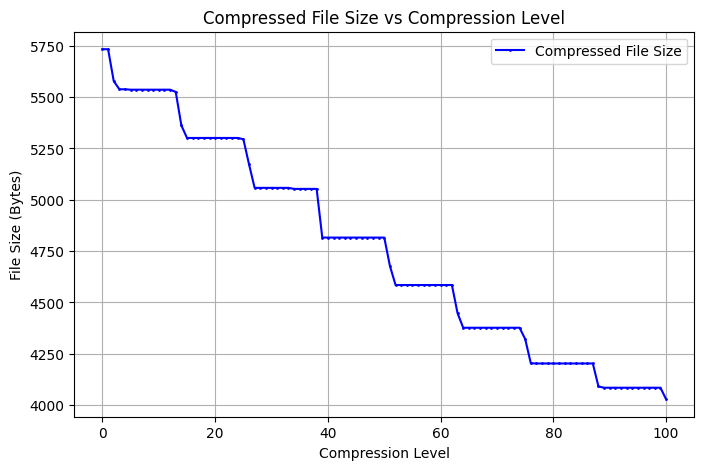

In [37]:
plot_floats_memory_usage(rnd_floats)

### Plot for floats distribution before and after compression.

In [19]:
def plot_distributions(floats: np.ndarray[np.float32], floats_compressed_recovered: np.ndarray[np.float32]) -> None:
    n = len(floats)
    k = int(np.ceil(np.log2(n) + 1))
    bins = k

    plt.figure(figsize=(10, 6))
    plt.hist(floats, bins=bins, edgecolor='black', alpha=0.5, label="Sampled numbers")
    plt.hist(floats_compressed_recovered, bins=bins, edgecolor='black', alpha=0.5, label="Recovered numbers")
    plt.title('Distribution')
    plt.xlabel('Float Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()
    plt.show()

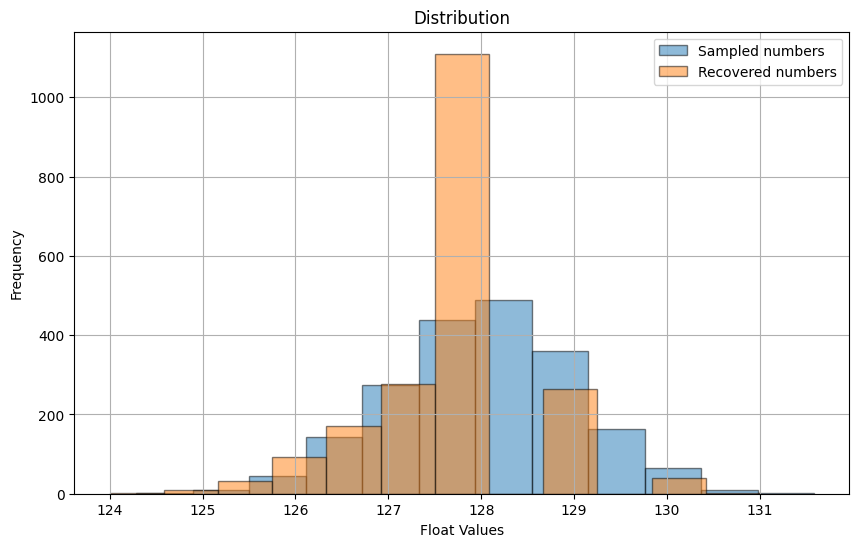

In [24]:
plot_distributions(rnd_floats, rnd_floats_compressed_recovered)

## 4.Conclusion

I explored a float compression technique based on removing the least significant bits. This is a simple method, but it has limitations. We can only use it when the relative error of a number (from $2^{-7}$ to $2^{-15}$) is not too much for us. I created an algorithm where we remove the same number of bits from numbers with the same sign and exponent. However, the curve of memory usage vs level compression was stepped.

I have several ideas to improve my current algorithm:

1. I believe developing an algorithm where we can remove n bits from one subset of numbers (even random subset) and n+1 bits from the others could solve this problem but it would be more time consuming.

2. We can also divide large groups with the same sign and exponent into smaller ones, allowing them to have a different number of bits removed.

3. When I recovered floats I added zero bits to the end, but in my opinion, it would be more logical to add 10..0 instead. This minor improvement can make MSE two times less.

I didn't have enough time to explore that ideas .

